In [1]:
import geopandas as gpd
import pandas as pd
from gerrychain import Graph
import random
import networkx as nx
import numpy as np

import facefinder
import numpy as np
import pandas as pd
import random
import pickle
import csv
import copy
import statistics
import math
import gerrychain
import networkx
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import os
import json
import argparse
from functools import partial
from gerrychain.tree import bipartition_tree as bpt
from gerrychain import Graph, MarkovChain
from gerrychain import accept
from gerrychain.constraints import (Validator, single_flip_contiguous,
                                    within_percent_of_ideal_population, UpperBound)
from gerrychain.proposals import propose_random_flip, propose_chunk_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges
from gerrychain import GeographicPartition
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap
from gerrychain.tree import recursive_tree_part, bipartition_tree_random, PopulatedGraph, random_spanning_tree
from collections import defaultdict
from datetime import datetime
import time
from concurrent.futures import ProcessPoolExecutor
import logging


In [2]:
def agglomerate(graph, agg_field = "dem_prop", agg_field_threshold = .5,  pop_cap = 6000, 
                steps = 1000000):
    # go through map, agglomerate VTDs that have similar EL16G_GV_D_block proportions, until pop_cap is reached
    # also allow merging of zero pop blocks with no condition.
    for i in range(steps):
        #if i % 100000 == 0:
            #print(i)
        if i % 10000 == 0:
            edges = list(graph.edges())
        e = random.choice(edges)
        if graph.has_edge(e[0], e[1]):

            if  (graph.nodes[e[0]]['TOTPOP_block'] == 0 or
                 graph.nodes[e[1]]['TOTPOP_block'] == 0 or
                 (graph.nodes[e[0]][agg_field] >  agg_field_threshold and 
                graph.nodes[e[1]][agg_field] >  agg_field_threshold)):
                tot_pop = graph.nodes[e[0]]['TOTPOP_block'] + graph.nodes[e[1]]['TOTPOP_block']
                tot_dem = graph.nodes[e[0]]['dem']+ graph.nodes[e[1]]['dem']
                tot_rep = graph.nodes[e[0]]['rep'] + graph.nodes[e[1]]['rep']
                #print(tot_pop)
                if tot_pop < pop_cap:
                    graph.nodes[e[0]]['cluster'] = graph.nodes[e[0]]['cluster'] + graph.nodes[e[1]]['cluster'] 
                    nx.contracted_nodes(graph, e[0], e[1], copy = False, self_loops = False)
                    # according to documentation node named e[0] remains
                    #print(e)
                    graph.nodes[e[0]]['TOTPOP_block'] = tot_pop
                    graph.nodes[e[0]]['dem'] = tot_dem
                    graph.nodes[e[0]]['rep'] = tot_rep
                    if tot_pop !=0 :

                        graph.nodes[e[0]]['dem_prop'] = tot_dem / tot_pop
                        graph.nodes[e[0]]['rep_prop'] = tot_rep / tot_pop
                    else:
                        graph.nodes[e[0]]['dem_prop'] = np.nan
                        graph.nodes[e[0]]['rep_prop'] = np.nan

In [3]:
def create_candidate(blocks_graph,
                     target_num_vtds = 4000,
                    dem_threshold = .7, dem_pop_cap = 8000, dem_steps = 200000,
                    rep_threshold = 0, rep_pop_cap = 2000, rep_steps = 2000,
                     final_push_vtd_target_size = 1000,
                     save = False,
                     print_progress = False
                    ):
    blocks_graph_test = blocks_graph_in.copy()
    if print_progress:
        print(f"Currently has {len(blocks_graph_test)} nodes")
    last = len(blocks_graph_test)
    for n in blocks_graph_test.nodes():
        blocks_graph_test.nodes[n]['cluster'] = [n]
    while len(blocks_graph_test) > target_num_vtds:
        agglomerate(graph = blocks_graph_test, agg_field = "dem_prop", 
                    agg_field_threshold = dem_threshold,  pop_cap = dem_pop_cap,  steps = dem_steps)
        agglomerate(graph = blocks_graph_test, agg_field = "rep_prop",  
                    agg_field_threshold = rep_threshold,  pop_cap = rep_pop_cap,  steps = rep_steps)
        if print_progress:
            print(f"Currently has {len(blocks_graph_test)} nodes")
        if len(blocks_graph_test) == last:
            # some more aggressive joining at this point
            agglomerate(graph = blocks_graph_test, agg_field = "rep_prop",  
                    agg_field_threshold = 0,  pop_cap = final_push_vtd_target_size,  steps = 2000000)
        last = len(blocks_graph_test)
    if print_progress:
        print("Finished. Stats:")    
        print(f"Has {len(blocks_graph_test)} VTDs")
        pops = []
        for node in blocks_graph_test.nodes():
            if blocks_graph_test.nodes[node]['dem'] > blocks_graph_test.nodes[node]['rep'] * 0:
                pops.append(blocks_graph_test.nodes[node]['TOTPOP_block'])
        pd.Series(pops).plot(kind = 'hist', bins = 30, title = "VTD pops")
        plt.show()
    name = str(datetime.now()).replace(" ", "").replace(":", "_")
    saved_name = f"candidate_blocks_graph{name}"
    if save == True:

        nx.write_gpickle(blocks_graph_test,f'./processed_data_outputs/{saved_name}.json')
    return blocks_graph_test, saved_name

In [4]:
def gerry(blocks_graph_test, gerrychain_steps = 10000, epsilon = .2, plot = False):
    updaters = {'population': Tally('population'),
                        'cut_edges': cut_edges,
                        }
    num_districts = 13
    ideal_population= sum( blocks_graph_test.nodes[x]["TOTPOP_block"] for x in blocks_graph_test.nodes())/ num_districts

    for n in blocks_graph_test.nodes():
        blocks_graph_test.nodes[n]["population"] =  blocks_graph_test.nodes[n]["TOTPOP_block"]
    
        
    # accept imported
    initial_partition_assignment =gerrychain.tree.recursive_tree_part(blocks_graph_test, 
                                                            range(num_districts), 
                                                            ideal_population, "population", epsilon)
    
    for n in blocks_graph_test.nodes():
        blocks_graph_test.nodes[n]["district"] = initial_partition_assignment[n]
    
    initial_partition = Partition(blocks_graph_test, assignment='district',  updaters=updaters)
    
    
    popbound = within_percent_of_ideal_population(initial_partition, epsilon)
    tree_proposal = partial(recom, pop_col = 'population', pop_target=ideal_population, epsilon=epsilon,
                                node_repeats=1)


    exp_chain = MarkovChain(tree_proposal, Validator([popbound]), accept=accept.always_accept,
                            initial_state=initial_partition, total_steps=gerrychain_steps)
    seats_won_for_republicans = []
    seats_won_for_democrats = []
    
    for part in exp_chain:
        rep_seats_won = 0
        dem_seats_won = 0
        for j in range(num_districts):
            rep_votes = 0
            dem_votes = 0
            for n in blocks_graph_test.nodes():
                if part.assignment[n] == j:
                    rep_votes += blocks_graph_test.nodes[n]["rep"]
                    dem_votes += blocks_graph_test.nodes[n]["dem"]
            total_seats_dem = int(dem_votes > rep_votes)
            total_seats_rep = int(rep_votes > dem_votes)
            rep_seats_won += total_seats_rep
            dem_seats_won += total_seats_dem
        seats_won_for_republicans.append(rep_seats_won)
        seats_won_for_democrats.append(dem_seats_won)

    rep_avg = statistics.mean(seats_won_for_republicans)
    dem_avg = statistics.mean(seats_won_for_democrats)
    
    if plot:
        print("avg rep seats ", rep_avg)
        print("avg dem seats ", dem_avg)

        pd.Series(seats_won_for_republicans).plot(kind = 'hist', title = 'rep seats')
        plt.show()
        plt.close()
    return dem_avg, rep_avg, seats_won_for_republicans

In [5]:
blocks_graph_in = Graph.from_json('./processed_data_outputs/blocks_graph.json')

In [6]:
def condensce_by_partition(graph, part):
    # given graph, and label field for each node, return graph where all the nodes with the same lable have been contracted
    # also, add up the pops and votes in each block
    graph_copy = graph.copy()
    
    for supernode in part.parts.values():
        nodes = list(supernode)
        for node in nodes[1:]:
            
            tot_pop = graph_copy.nodes[nodes[0]]['TOTPOP_block'] + graph_copy.nodes[node]['TOTPOP_block']
            tot_dem = graph_copy.nodes[nodes[0]]['dem']+ graph_copy.nodes[node]['dem']
            tot_rep = graph_copy.nodes[nodes[0]]['rep'] + graph_copy.nodes[node]['rep']
            nx.contracted_nodes(graph_copy, nodes[0], node, copy = False)
            graph_copy.nodes[nodes[0]]['TOTPOP_block'] = tot_pop
            graph_copy.nodes[nodes[0]]['dem'] = tot_dem
            graph_copy.nodes[nodes[0]]['rep'] = tot_rep
            
    return graph_copy

Currently has 288987 nodes
Currently has 226155 nodes
Currently has 190089 nodes
Currently has 165526 nodes
Currently has 145280 nodes
Currently has 126899 nodes
Currently has 109753 nodes
Currently has 93795 nodes
Currently has 79273 nodes
Currently has 66424 nodes
Currently has 55491 nodes
Currently has 46571 nodes
Currently has 39532 nodes
Currently has 34267 nodes
Currently has 30353 nodes
Currently has 27627 nodes
Finished. Stats:
Has 27627 VTDs


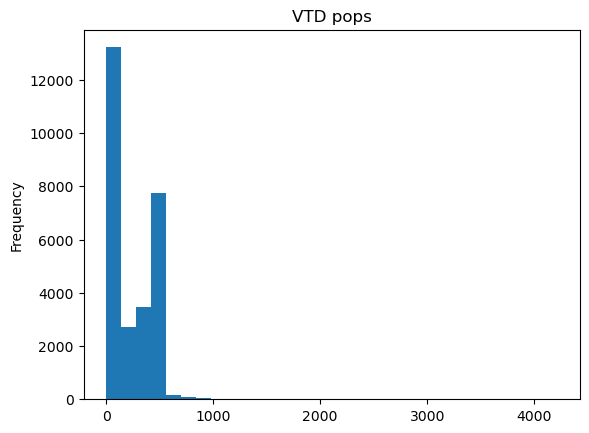

In [7]:
blocks_graph_test, saved_name = create_candidate(blocks_graph_in,               
                    target_num_vtds = 30000,
                    dem_threshold = .7, dem_pop_cap = 500, dem_steps = 200000,
                    rep_threshold = 0, rep_pop_cap = 500, rep_steps = 20000,
                                                 final_push_vtd_target_size = 500,
                                                 save = False, print_progress = True)

Search

In [9]:
# num_vtds = 13
# for n in blocks_graph_test.nodes():
#     blocks_graph_test.nodes[n]["population"] =  1
#     #blocks_graph_test.nodes[n]["population"] = round( blocks_graph_test.nodes[n]["TOTPOP_block"],0)



# ideal_population= sum( blocks_graph_test.nodes[x]["population"] for x in blocks_graph_test.nodes())/ num_vtds

# initial_partition_assignment =gerrychain.tree.recursive_tree_part(blocks_graph_test, 
                                                            
#                                                             range(num_vtds), ideal_population,
#                                                                   "population", epsilon = .8)


# for n in blocks_graph_test.nodes():
#     blocks_graph_test.nodes[n]["district"] = initial_partition_assignment[n]

    
# initial_partition = Partition(blocks_graph_test, assignment='district',  updaters=updaters)




# epsilon = .8
# gerrychain_steps = 50000
# steps_in_between = 1000
# test_step_steps = 2000
# validate_steps = 20000

# current_part = initial_partition
# seats_won_for_republicans = []
# seats_won_for_democrats = []
# i = 0

# # for i in range(1000):


# initial_partition = current_part
# popbound = within_percent_of_ideal_population(initial_partition, epsilon)
# tree_proposal = partial(recom, pop_col = 'population', pop_target=ideal_population, epsilon=epsilon,
#                             node_repeats=1)


# exp_chain = MarkovChain(tree_proposal, Validator([]), accept=accept.always_accept,
#                         initial_state=initial_partition, total_steps=gerrychain_steps)



In [115]:
edge_list = list(blocks_graph_test.edges())

random.shuffle(edge_list)

graph = blocks_graph_test

In [145]:
pops = []
for node in blocks_graph_test.nodes():
    if blocks_graph_test.nodes[node]['dem'] > blocks_graph_test.nodes[node]['rep'] * 0:
        pops.append(blocks_graph_test.nodes[node]['TOTPOP_block'])

print("total pop" , pd.Series(pops).sum() )

total pop 6271643.357772534


In [189]:
def conditional_contract(part, edge, graph, top_pop_filter = 5000):
    if edge[0] == edge[1]:
        return False
   
#     if edge[0] in graph.nodes():
#         debugblah = graph.nodes[edge[0]]['TOTPOP_block']
#     else:
#         debugblah = 0
#     current_size = len(graph.nodes())
#     if debugblah > 1000:
#         print("debug -before ", pops(graph), current_size,
#               graph.nodes[edge[0]]['TOTPOP_block'] , graph.nodes[edge[1]]['TOTPOP_block'] )
    if part.assignment[edge[0]] == part.assignment[edge[1]]:
        if edge[0] in graph.nodes() and edge[1] in graph.nodes():
            tot_pop = graph.nodes[edge[0]]['TOTPOP_block'] + graph.nodes[edge[1]]['TOTPOP_block']
            tot_dem = graph.nodes[edge[0]]['dem']+ graph.nodes[edge[1]]['dem']
            tot_rep = graph.nodes[edge[0]]['rep'] + graph.nodes[edge[1]]['rep']
            if tot_pop < top_pop_filter:

                nx.contracted_nodes(graph, edge[0], edge[1], copy = False)
                ### um... this function seems to be broken, somtimes v remains in the graph 
#                 if len(graph.nodes()) == current_size:
#                     print(edge[0], edge[1])
                
                graph.nodes[edge[0]]['TOTPOP_block'] = tot_pop
                graph.nodes[edge[0]]['dem'] = tot_dem
                graph.nodes[edge[0]]['rep'] = tot_rep
#                 if debugblah > 1000:
#                     print("debug - after ", len(graph.nodes()),
#                           pops(graph), graph.nodes[edge[0]]['TOTPOP_block'] )
 
                return True
    return False

def pops(graph):
    pops = []
    for node in graph.nodes():
        pops.append(graph.nodes[node]['TOTPOP_block'])
    return pd.Series(pops).sum()
    print("total pop" , pd.Series(pops).sum() )

def metamander_around_helper(part, graph, num_vtds = 2000,
                             max_size = 2000, num_loops = 10):
    graph_copy = graph.copy()
    previous = 0
    
    
    for i in range(5):
        current_size = len(graph_copy)
        pops(graph_copy)
        nodes = list(graph_copy.nodes())
        small_nodes = [ x for x in nodes if graph_copy.nodes[x]['TOTPOP_block'] < 15]
        
        if current_size != previous:
            print(current_size, len(small_nodes), 
                 max(dict(graph_copy.degree).values()))
            
            previous = current_size
        if len(small_nodes) <= 200:
            break
        for node in small_nodes:
            if node in graph_copy.nodes():
                for n in list(graph_copy.neighbors(node)):
                    if conditional_contract(part, (node, n), graph_copy, 
                                            top_pop_filter = max_size):
                        break

    #list_of_blocks = [set(x) for x in part.parts.values()]
    for i in range(1, num_loops):
        tick = 0
        print(f'loop {i}')
        while len(graph_copy) >= num_vtds and tick < 5:
            #print("size" , pops(graph_copy))
            tick +=1 
            current_size = len(graph_copy)
            if current_size != previous:
                print(current_size,  max(dict(graph_copy.degree).values()))
                previous = current_size
            edge_list = list(graph_copy.edges())
            edge_list = sorted(edge_list,
                               key = lambda x : graph.nodes[x[0]]['TOTPOP_block'] + graph.nodes[x[1]]['TOTPOP_block']) 

            for edge in edge_list:
                conditional_contract(part, edge, graph_copy, 
                                     top_pop_filter = int ( max_size * i / num_loops))
   
            
    return graph_copy


def metamander_around_part(part, graph, num_vtds = 2000, max_size = 2000,
                           gerrychain_steps = 2000, run_gerrychain = True):
    metamandered_graph = metamander_around_helper(part = part, max_size = max_size,
                                           graph = graph, num_vtds = num_vtds)
    print("Finished creating metamander candidate")
    
    
    print("VTD stats")
    pops = []
    for node in metamandered_graph.nodes():
        if metamandered_graph.nodes[node]['dem'] > metamandered_graph.nodes[node]['rep'] * 0:
            pops.append(metamandered_graph.nodes[node]['TOTPOP_block'])
    
    pd.Series(pops).plot(kind = 'hist', bins = 30, title = "VTD pops")
    print("total pop" , pd.Series(pops).sum() )
    plt.show()
    display(pd.Series(pops).describe())
    
    if run_gerrychain:
        dem_avg, rep_avg, seats_won_for_republicans = gerry(metamandered_graph, 
                                                        gerrychain_steps = gerrychain_steps, 
                                                        plot = True)
    else:
        dem_avg, rep_avg = None, None
        
  
    
    return dem_avg, rep_avg, metamandered_graph

27627 5564 49
22106 28 32
loop 1
4928 42
1255 30
425 31
144 35
loop 2
33 13
loop 3
loop 4
loop 5
loop 6
loop 7
loop 8
loop 9
Finished creating metamander candidate
VTD stats
total pop 6271643.357772534


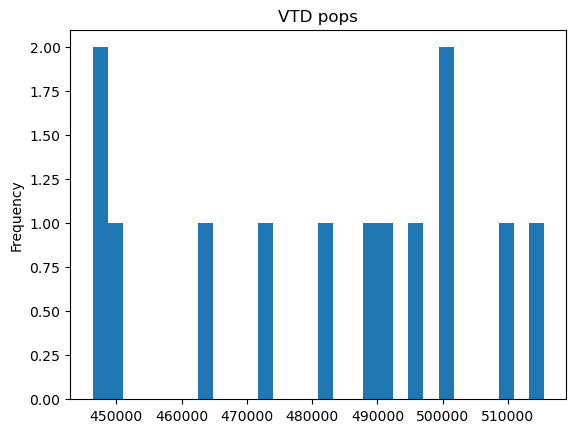

count        13.000000
mean     482434.104444
std       23929.695452
min      446385.888389
25%      464721.448033
50%      489579.515698
75%      499732.394297
max      515481.288017
dtype: float64

IndexError: list index out of range

In [197]:
dem_avg, rep_avg, metamandered_graph = metamander_around_part(part = part, 
                                          graph = blocks_graph_test, 
                                          num_vtds = 30, max_size = 20000000,
                                            run_gerrychain = True)

In [78]:
gerrychain_steps = 10000
epsilon = .1

updaters = {'population': Tally('population'),
                    'cut_edges': cut_edges,
                    }
num_districts = 13
ideal_population= sum( blocks_graph_test.nodes[x]["TOTPOP_block"] for x in blocks_graph_test.nodes())/ num_districts

for n in blocks_graph_test.nodes():
    blocks_graph_test.nodes[n]["population"] =  blocks_graph_test.nodes[n]["TOTPOP_block"]


# accept imported
initial_partition_assignment =gerrychain.tree.recursive_tree_part(blocks_graph_test, 
                                                        range(num_districts), 
                                                        ideal_population, "population", epsilon)

for n in blocks_graph_test.nodes():
    blocks_graph_test.nodes[n]["district"] = initial_partition_assignment[n]

initial_partition = Partition(blocks_graph_test, assignment='district',  updaters=updaters)


popbound = within_percent_of_ideal_population(initial_partition, epsilon)
tree_proposal = partial(recom, pop_col = 'population', pop_target=ideal_population, epsilon=epsilon,
                            node_repeats=1)


exp_chain = MarkovChain(tree_proposal, Validator([popbound]), accept=accept.always_accept,
                        initial_state=initial_partition, total_steps=gerrychain_steps)
seats_won_for_republicans = []
seats_won_for_democrats = []
print('in chain')



KeyboardInterrupt



27627 5564 49
22142 64 32
7318 34
3395
Finished creating metamander candidate
avg rep seats  7.866
avg dem seats  5.134


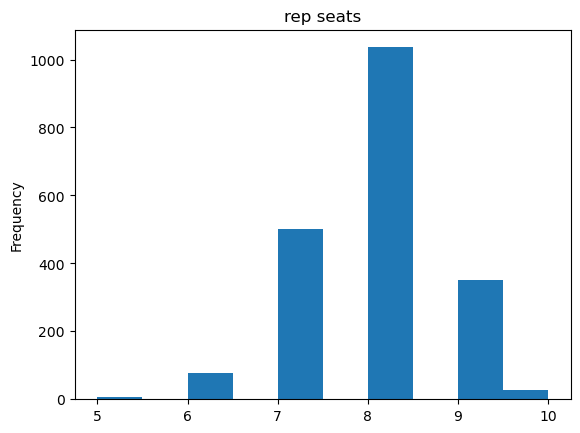

VTD stats


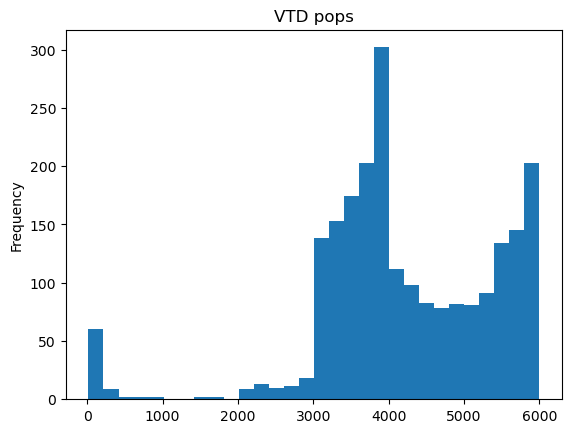

count    2217.000000
mean     4211.334010
std      1215.919925
min        15.601861
25%      3550.797100
50%      4003.198075
75%      5230.347324
max      5999.934179
dtype: float64

27627 5564 49
22142 64 32
7345 33
3361
Finished creating metamander candidate
avg rep seats  7.4455
avg dem seats  5.5545


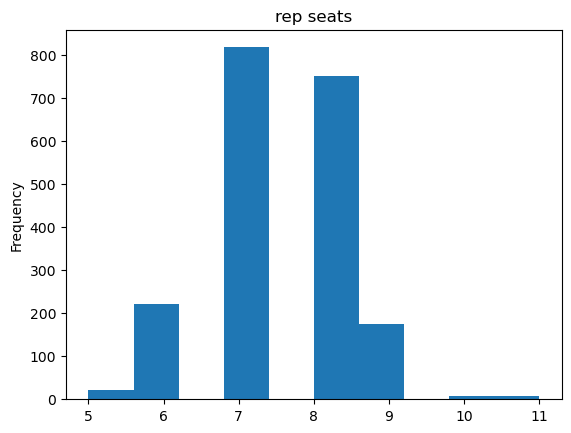

VTD stats


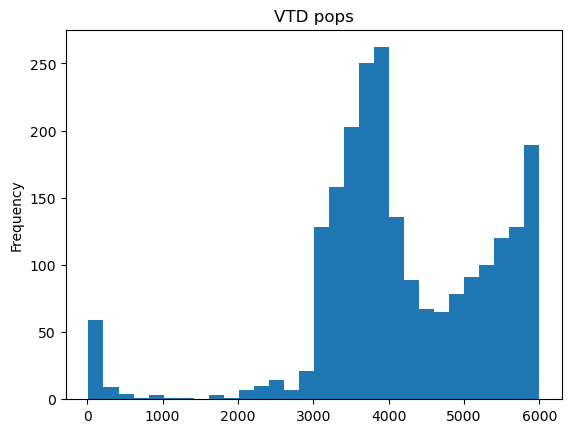

count    2205.000000
mean     4165.716904
std      1206.601850
min        15.564704
25%      3521.080902
50%      3971.940068
75%      5169.471297
max      5999.720065
dtype: float64

27627 5564 49
22142 64 32
7363 35
3434
Finished creating metamander candidate
avg rep seats  7.6795
avg dem seats  5.3205


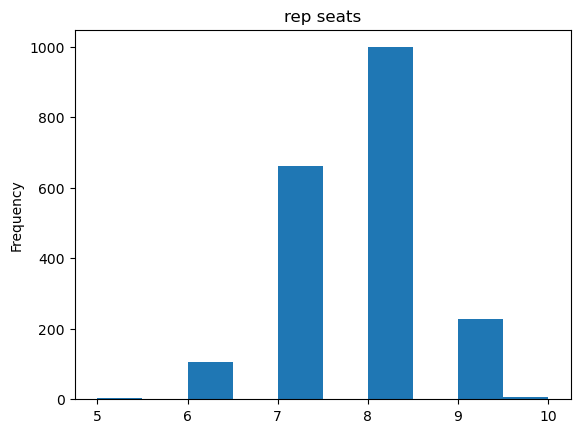

VTD stats


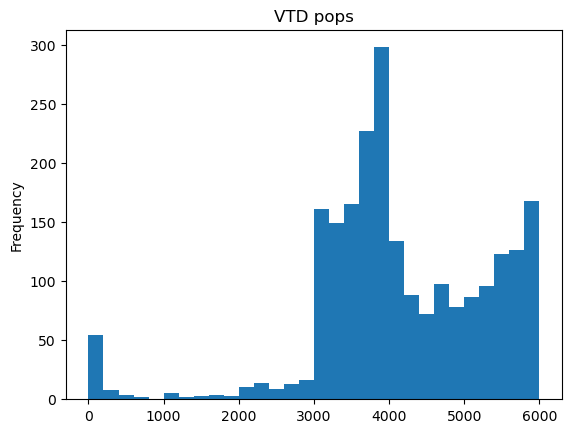

count    2217.000000
mean     4148.035194
std      1192.958617
min         0.646199
25%      3521.251031
50%      3974.843756
75%      5112.881677
max      5999.224216
dtype: float64

27627 5564 49
22142 64 32
7320 34
3389
Finished creating metamander candidate
avg rep seats  7.656
avg dem seats  5.344


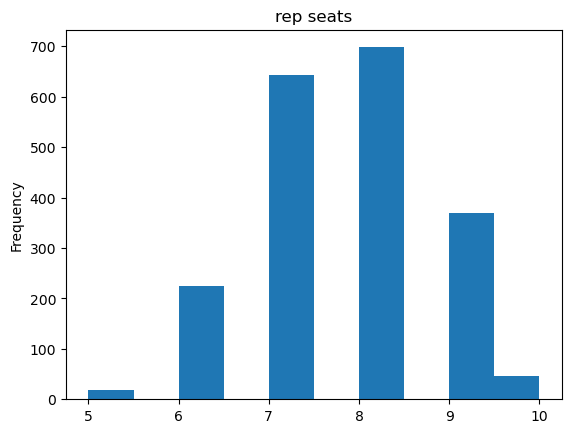

VTD stats


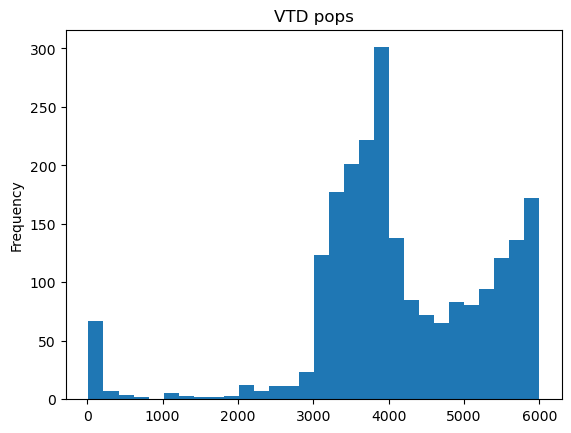

count    2230.000000
mean     4130.487098
std      1224.763669
min        15.222538
25%      3512.255100
50%      3961.598064
75%      5121.944428
max      5998.481308
dtype: float64

27627 5564 49
22142 64 32
7382 35
3427
Finished creating metamander candidate
avg rep seats  7.5855
avg dem seats  5.4145


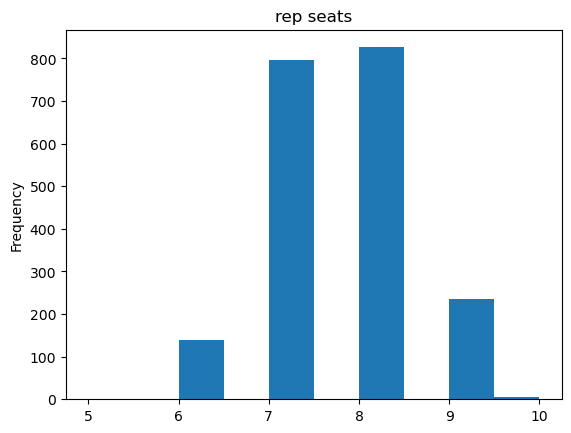

VTD stats


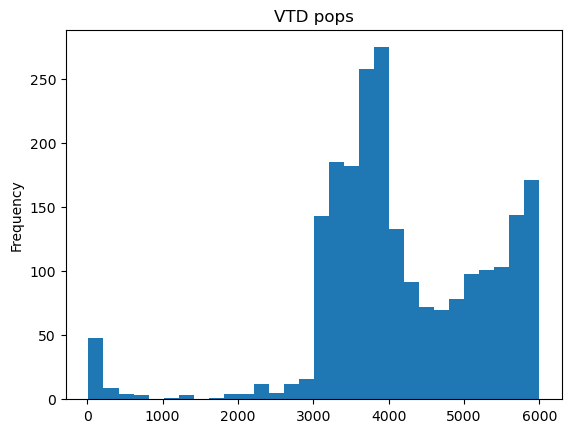

count    2227.000000
mean     4170.510007
std      1159.601676
min        15.209385
25%      3530.768898
50%      3970.501638
75%      5114.389836
max      5999.378006
dtype: float64

27627 5564 49
22142 64 32
7278 35
3379
Finished creating metamander candidate
27627 5564 49
22142 64 32
7303 36
3390
Finished creating metamander candidate
avg rep seats  7.698
avg dem seats  5.302


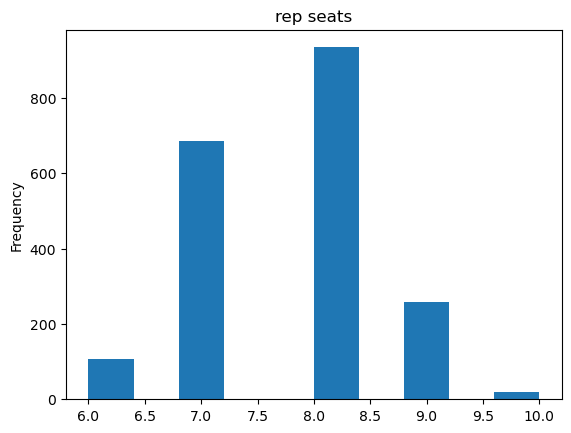

VTD stats


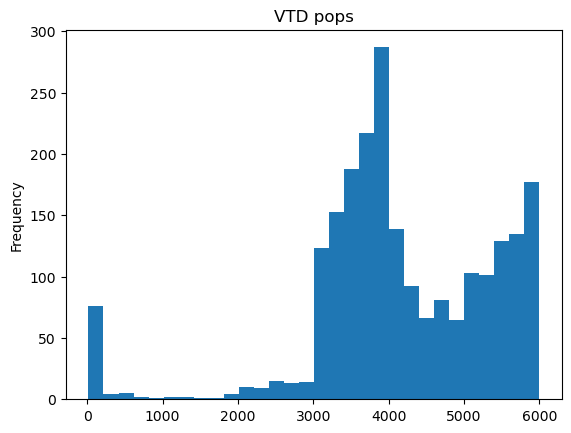

count    2215.000000
mean     4157.973543
std      1251.710572
min        15.209385
25%      3533.678182
50%      3995.983608
75%      5185.332133
max      5999.524316
dtype: float64

27627 5564 49
22142 64 32
7286 34
3377
Finished creating metamander candidate
avg rep seats  7.374
avg dem seats  5.626


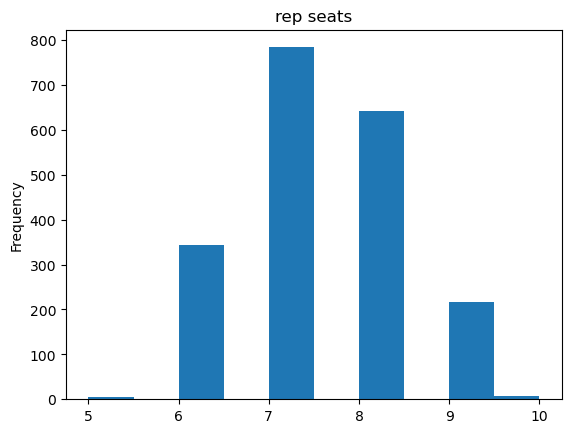

VTD stats


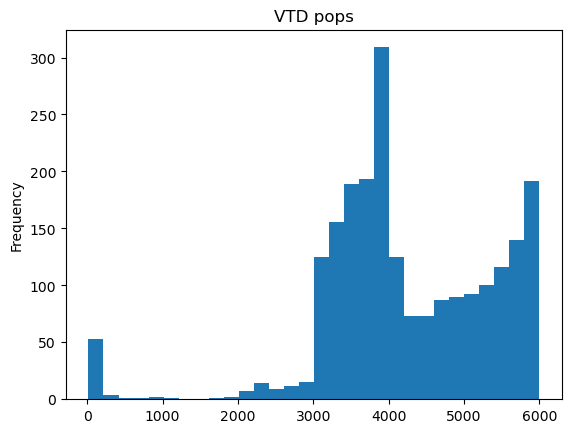

count    2182.000000
mean     4228.996282
std      1168.395350
min        15.475220
25%      3563.775394
50%      4003.227412
75%      5208.236067
max      5999.020620
dtype: float64

27627 5564 49
22142 64 32
7340 30
3408
Finished creating metamander candidate
avg rep seats  7.779
avg dem seats  5.221


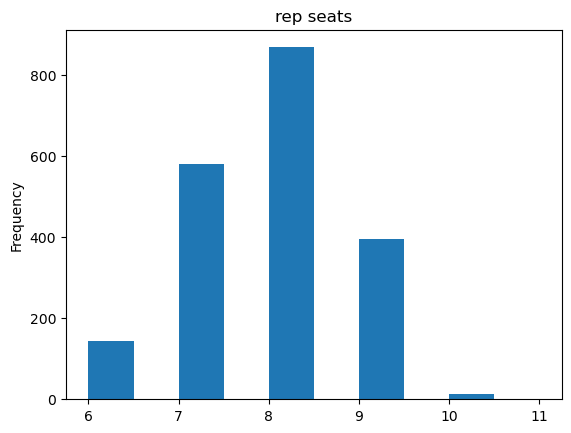

VTD stats


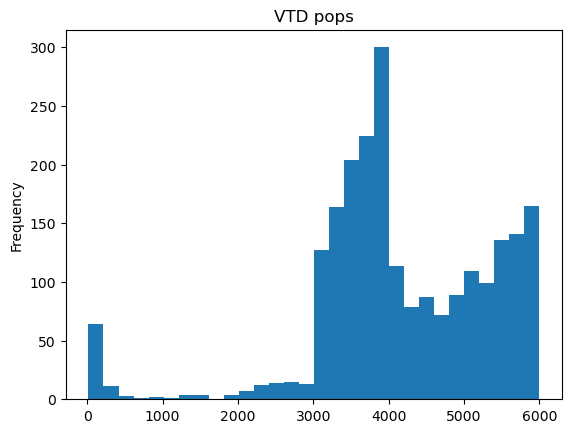

count    2265.000000
mean     4160.089791
std      1219.901447
min        15.053878
25%      3530.397332
50%      3979.569598
75%      5170.545787
max      5999.857292
dtype: float64

27627 5564 49
22142 64 32
7324 30
3381
Finished creating metamander candidate
avg rep seats  7.5415
avg dem seats  5.4585


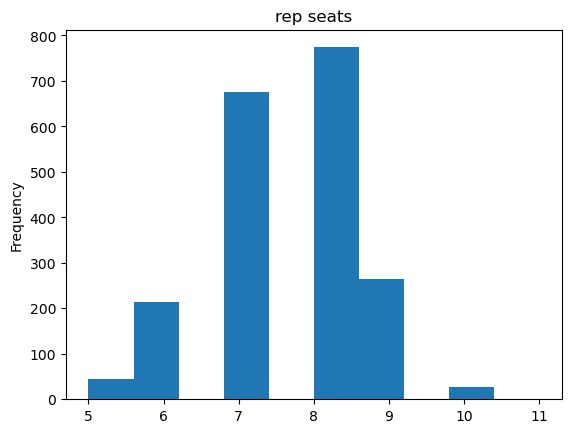

VTD stats


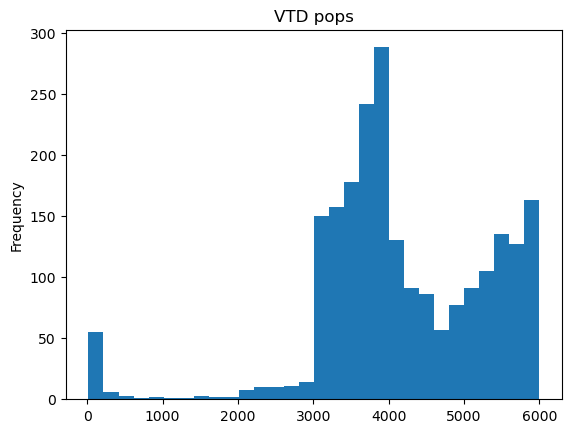

count    2206.000000
mean     4171.613640
std      1177.053984
min        15.475220
25%      3533.139879
50%      3974.700258
75%      5166.613920
max      5999.775412
dtype: float64

27627 5564 49
22142 64 32
7395 32
3387
Finished creating metamander candidate
27627 5564 49
22142 64 32
7292 37
3401
Finished creating metamander candidate
27627 5564 49
22142 64 32
7319 34
3403
Finished creating metamander candidate
avg rep seats  7.6815
avg dem seats  5.3185


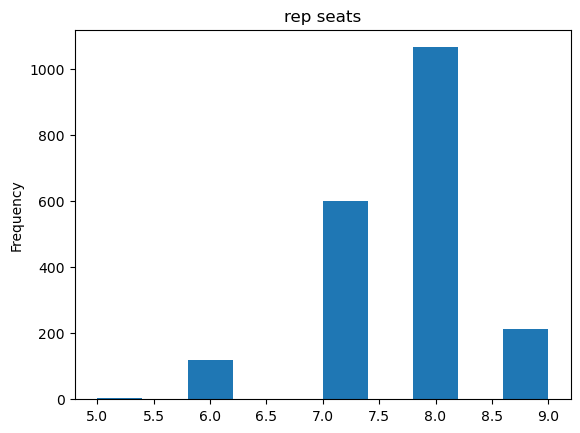

VTD stats


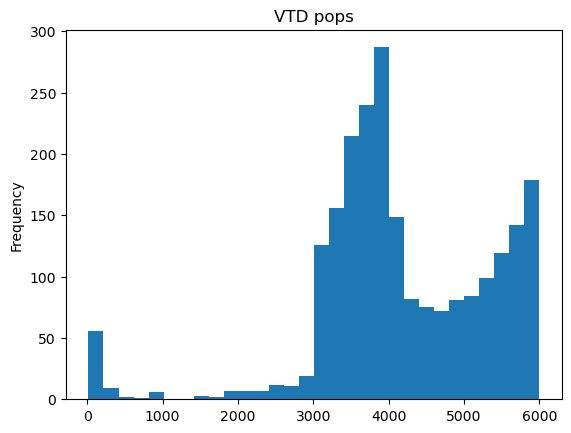

count    2248.000000
mean     4166.513142
std      1188.425338
min        15.015284
25%      3536.749124
50%      3977.474234
75%      5159.486664
max      5999.332034
dtype: float64

27627 5564 49
22142 64 32
7344 33
3394
Finished creating metamander candidate
avg rep seats  7.6475
avg dem seats  5.3525


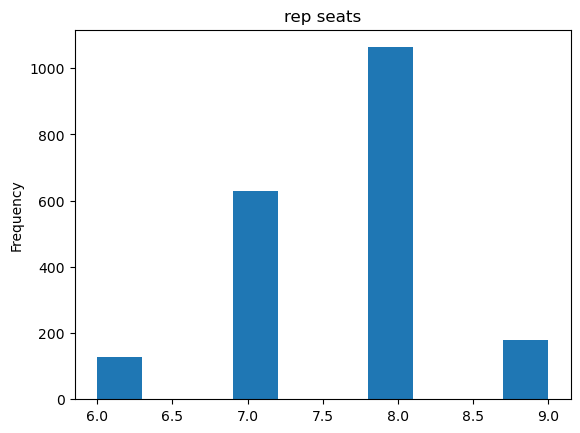

VTD stats


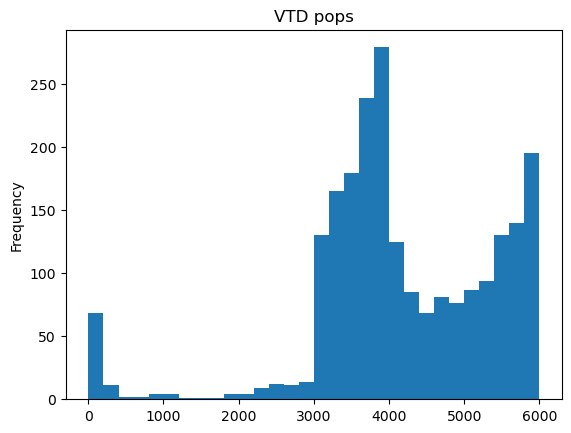

count    2221.000000
mean     4167.948718
std      1249.998322
min         1.938596
25%      3528.804484
50%      3982.193848
75%      5210.793527
max      5999.528715
dtype: float64

27627 5564 49
22142 64 32
7372 35
3410
Finished creating metamander candidate
avg rep seats  7.7625
avg dem seats  5.2375


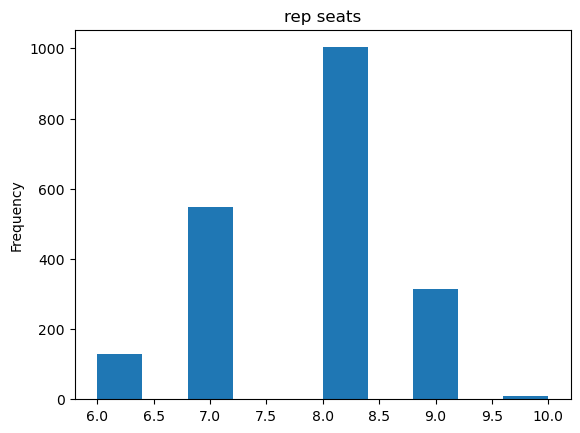

VTD stats


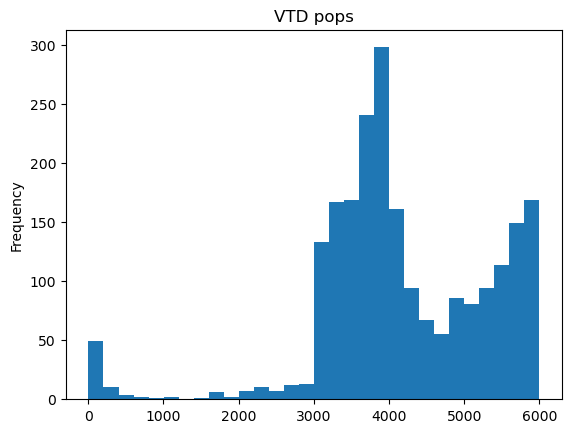

count    2204.000000
mean     4172.815941
std      1171.976690
min         1.938596
25%      3552.982102
50%      3986.152046
75%      5144.668802
max      5999.249878
dtype: float64

27627 5564 49
22142 64 32
7320 33
3415
Finished creating metamander candidate
27627 5564 49
22142 64 32
7408 33
3403
Finished creating metamander candidate
avg rep seats  7.5015
avg dem seats  5.4985


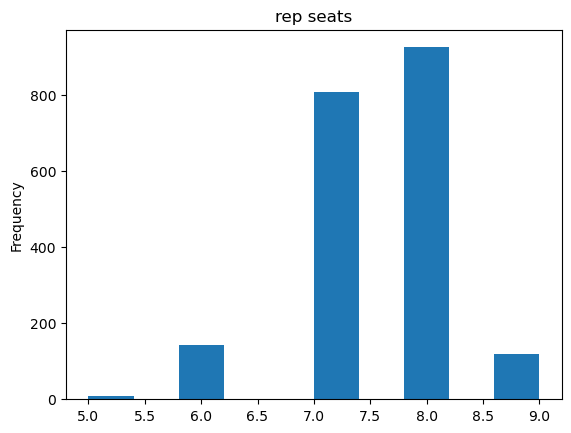

VTD stats


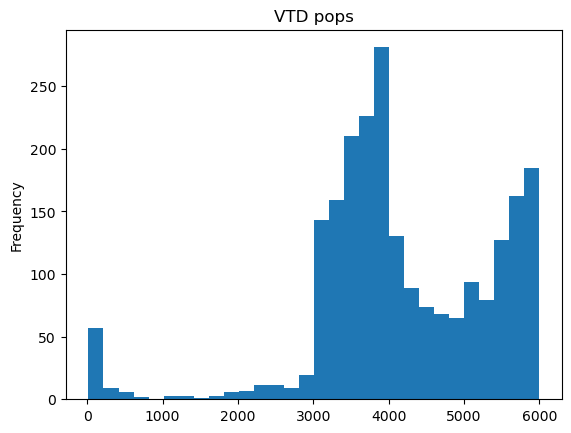

count    2239.000000
mean     4166.964703
std      1216.749062
min        15.487441
25%      3520.155106
50%      3964.695086
75%      5188.958402
max      5999.829476
dtype: float64

27627 5564 49
22142 64 32
7359 33
3406
Finished creating metamander candidate
avg rep seats  7.6675
avg dem seats  5.3325


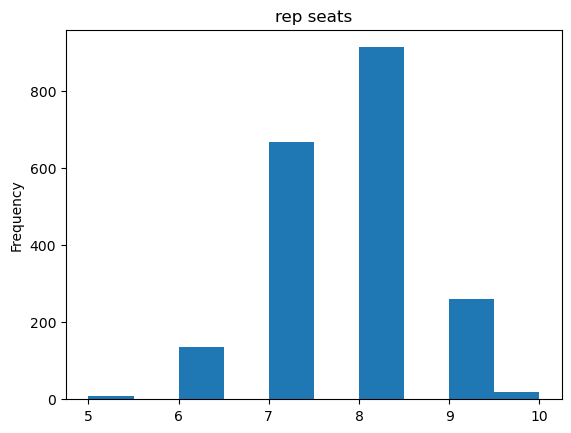

VTD stats


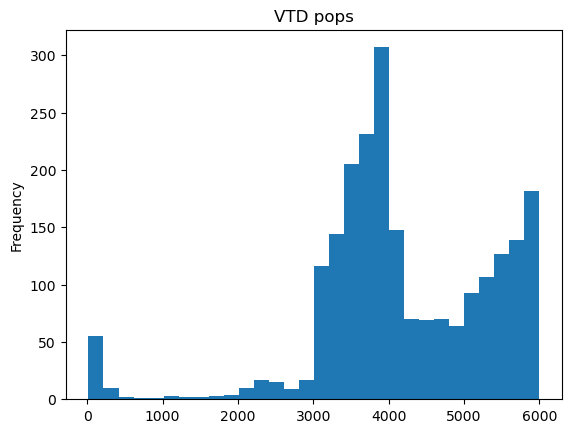

count    2223.000000
mean     4177.929641
std      1201.748940
min        15.015284
25%      3553.092302
50%      3976.007203
75%      5200.361947
max      5999.852363
dtype: float64

27627 5564 49
22142 64 32
7329 36
3348
Finished creating metamander candidate
avg rep seats  7.7875
avg dem seats  5.2125


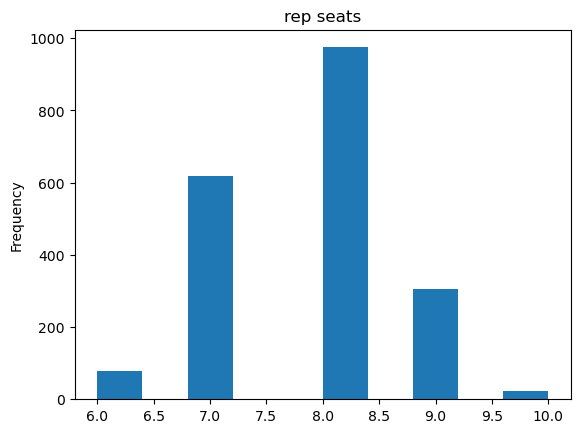

VTD stats


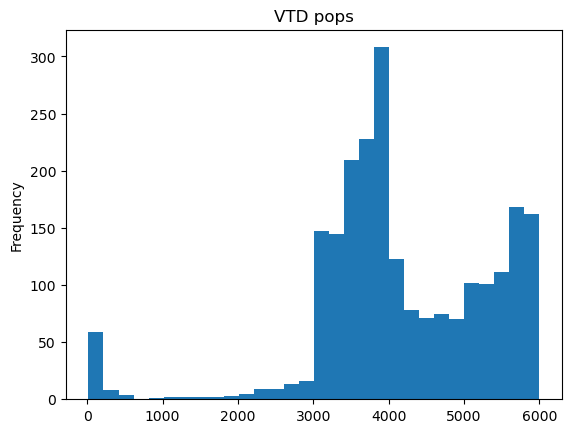

count    2233.000000
mean     4172.322065
std      1197.618618
min        15.159638
25%      3543.645706
50%      3971.453491
75%      5175.426842
max      5999.658813
dtype: float64

27627 5564 49
22142 64 32
7342 33
3420
Finished creating metamander candidate
avg rep seats  7.3635
avg dem seats  5.6365


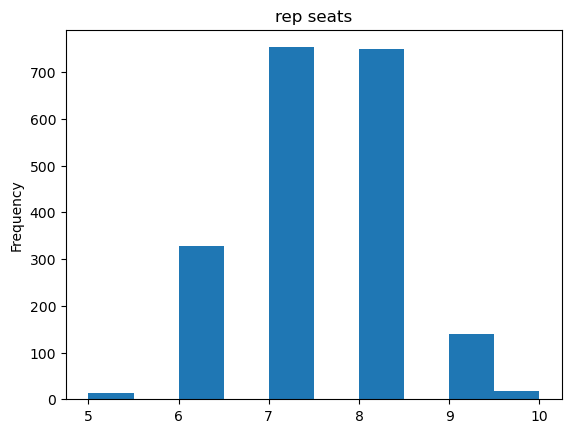

VTD stats


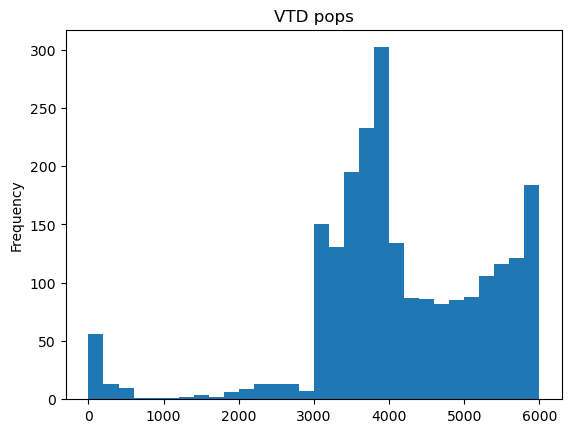

count    2251.000000
mean     4147.661086
std      1216.697079
min         0.646199
25%      3534.838818
50%      3981.709782
75%      5124.775586
max      5999.717484
dtype: float64

27627 5564 49
22142 64 32
7354 37
3425
Finished creating metamander candidate
27627 5564 49
22142 64 32
7394 38
3407
Finished creating metamander candidate
avg rep seats  7.857
avg dem seats  5.143


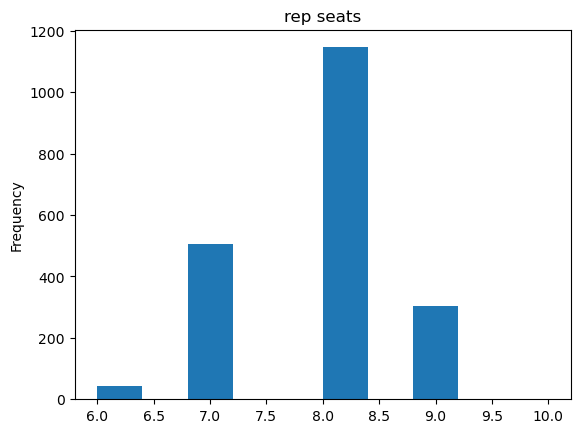

VTD stats


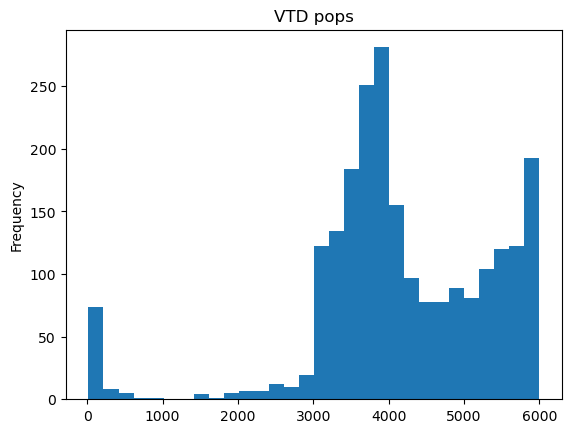

count    2243.000000
mean     4162.150718
std      1236.603252
min        15.295709
25%      3577.167380
50%      4001.252180
75%      5154.859090
max      5999.908131
dtype: float64

27627 5564 49
22142 64 32
7376 27
3373
Finished creating metamander candidate
avg rep seats  7.7965
avg dem seats  5.2035


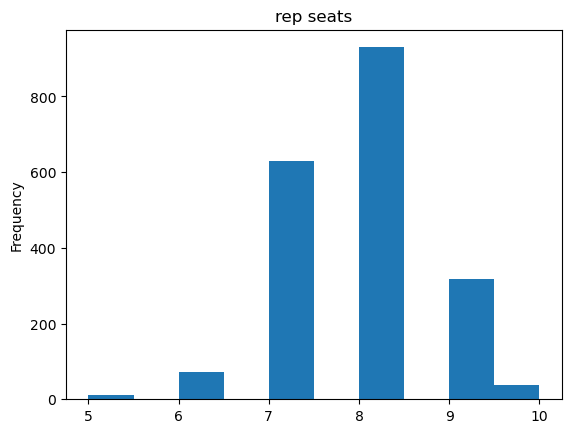

VTD stats


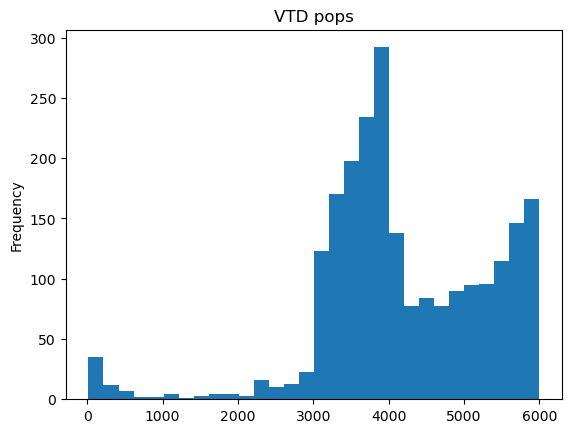

count    2240.000000
mean     4183.573682
std      1144.066399
min        15.475220
25%      3546.456361
50%      3983.350107
75%      5107.079836
max      5999.477891
dtype: float64

27627 5564 49
22142 64 32
7293 30
3374
Finished creating metamander candidate
avg rep seats  7.7205
avg dem seats  5.2795


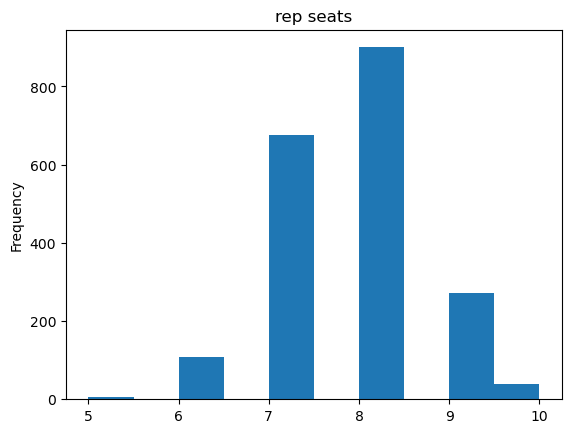

VTD stats


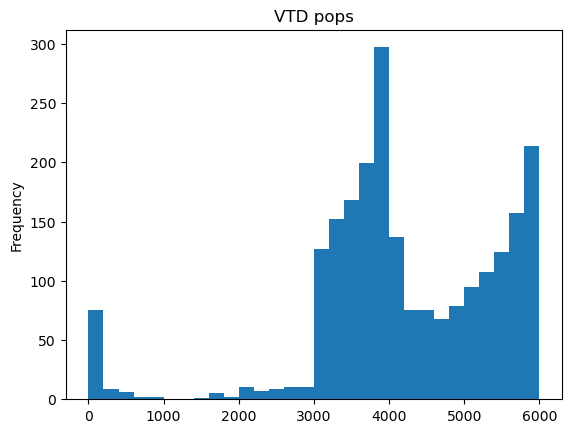

count    2222.000000
mean     4205.663952
std      1280.376299
min         0.646199
25%      3553.166783
50%      4011.114643
75%      5290.614204
max      5999.579258
dtype: float64

27627 5564 49
22142 64 32
7344 31
3419
Finished creating metamander candidate
27627 5564 49
22142 64 32
7333 28
3441
Finished creating metamander candidate
avg rep seats  7.8005
avg dem seats  5.1995


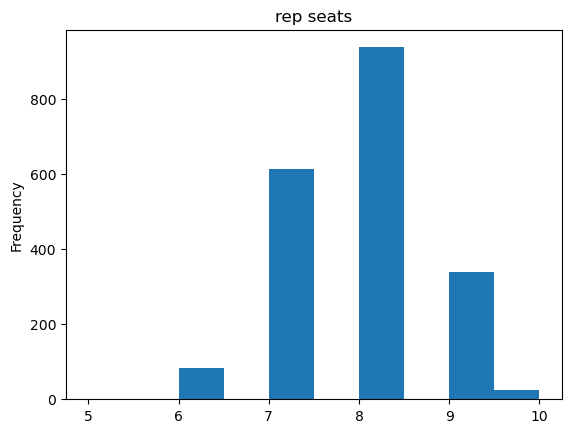

VTD stats


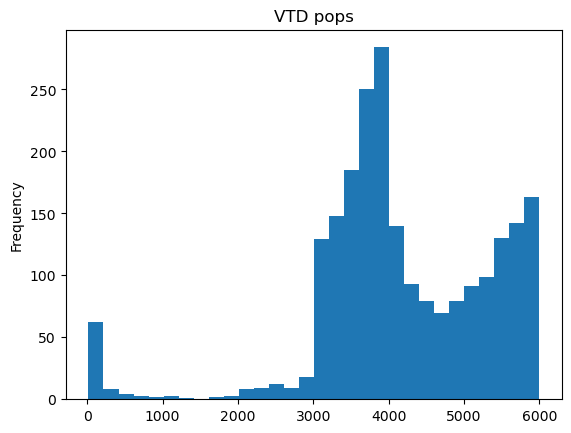

count    2226.000000
mean     4166.352430
std      1205.961297
min        15.366569
25%      3541.863450
50%      3985.939051
75%      5154.335786
max      5999.499294
dtype: float64

27627 5564 49
22142 64 32
7345 31
3413
Finished creating metamander candidate
avg rep seats  7.382
avg dem seats  5.618


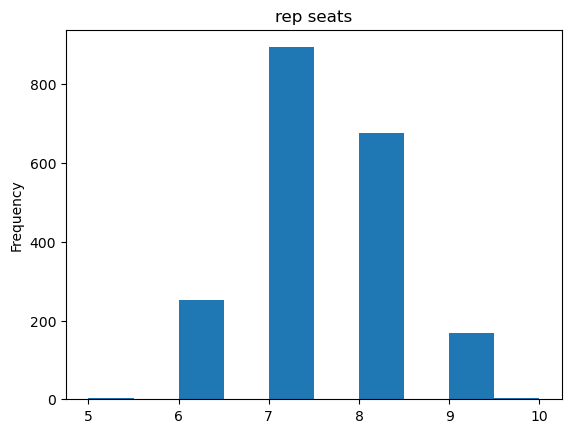

VTD stats


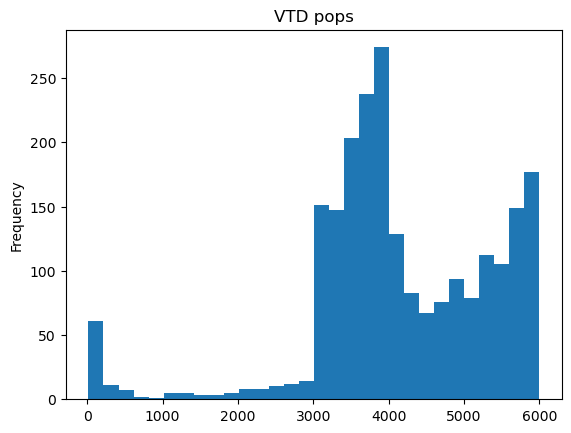

count    2239.000000
mean     4142.750981
std      1233.786871
min        15.053878
25%      3512.727040
50%      3969.956716
75%      5177.217473
max      5999.976494
dtype: float64

27627 5564 49
22142 64 32
7360 33
3429
Finished creating metamander candidate
avg rep seats  7.4945
avg dem seats  5.5055


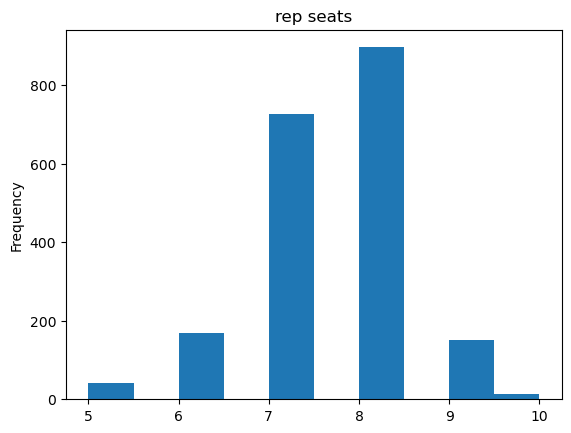

VTD stats


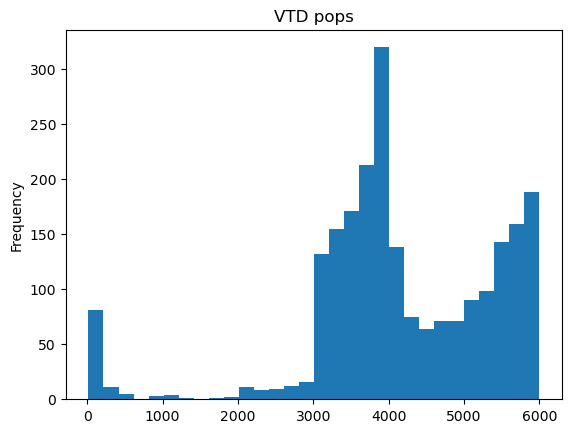

count    2252.000000
mean     4163.250431
std      1284.814127
min        15.015284
25%      3551.847214
50%      3988.751129
75%      5256.677770
max      5999.757168
dtype: float64

27627 5564 49
22142 64 32
7336 41
3382
Finished creating metamander candidate
avg rep seats  7.2165
avg dem seats  5.7835


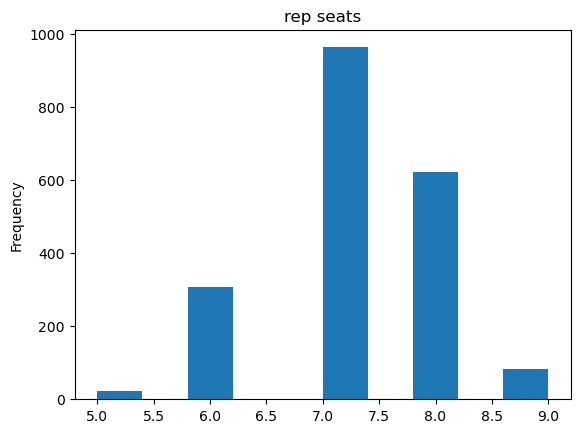

VTD stats


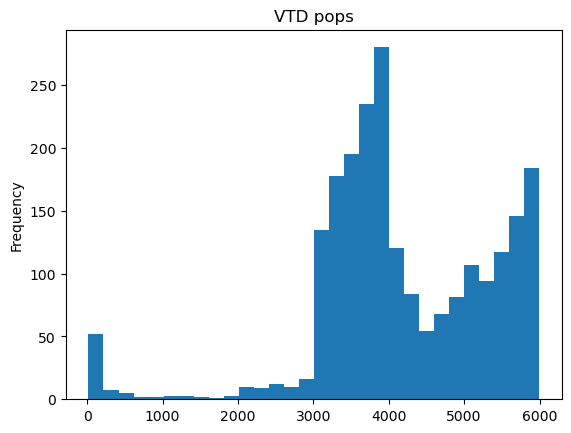

count    2215.000000
mean     4179.285626
std      1197.666758
min        15.053878
25%      3524.010392
50%      3971.752475
75%      5181.941993
max      5997.990368
dtype: float64

27627 5564 49
22142 64 32
7331 28
3425
Finished creating metamander candidate
avg rep seats  7.615
avg dem seats  5.385


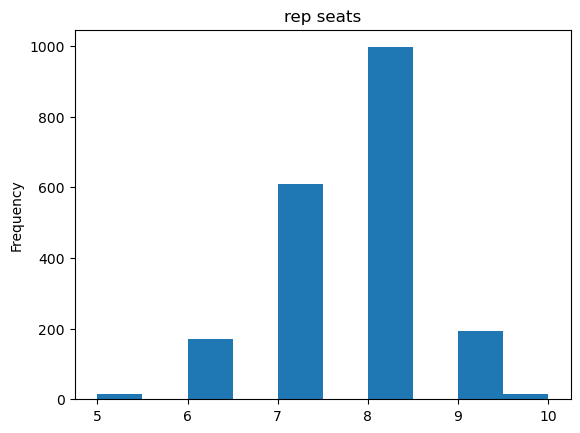

VTD stats


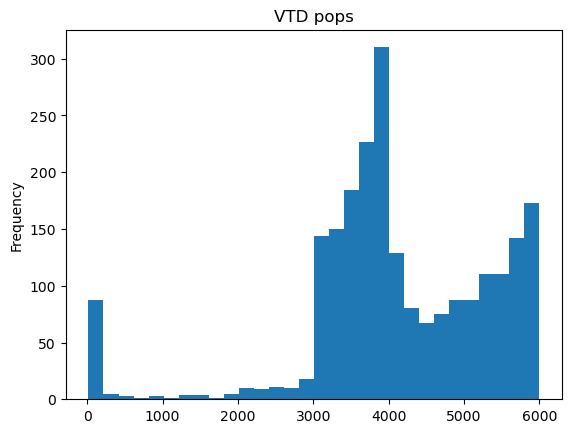

count    2247.000000
mean     4113.387834
std      1276.362997
min        15.209385
25%      3509.731425
50%      3962.347502
75%      5145.775966
max      5999.915198
dtype: float64

27627 5564 49
22142 64 32
7292 35
3359
Finished creating metamander candidate
27627 5564 49
22142 64 32
7381 37
3392
Finished creating metamander candidate
avg rep seats  7.3515
avg dem seats  5.6485


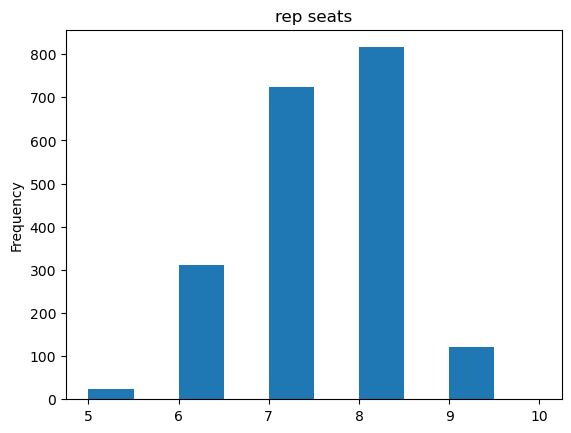

VTD stats


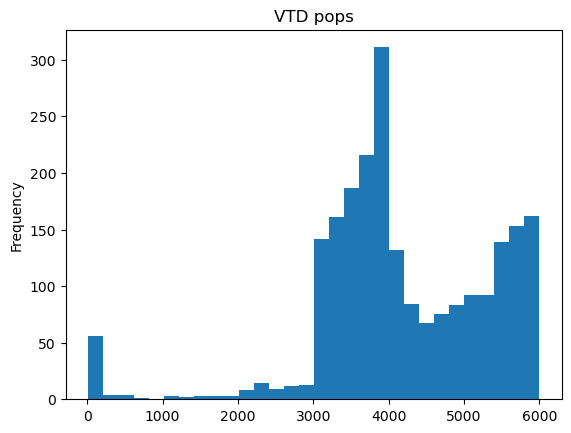

count    2231.000000
mean     4184.556629
std      1184.330853
min        15.061336
25%      3544.091563
50%      3985.763943
75%      5174.760128
max      5999.870821
dtype: float64

27627 5564 49
22142 64 32
7285 30
3286
Finished creating metamander candidate
avg rep seats  7.725
avg dem seats  5.275


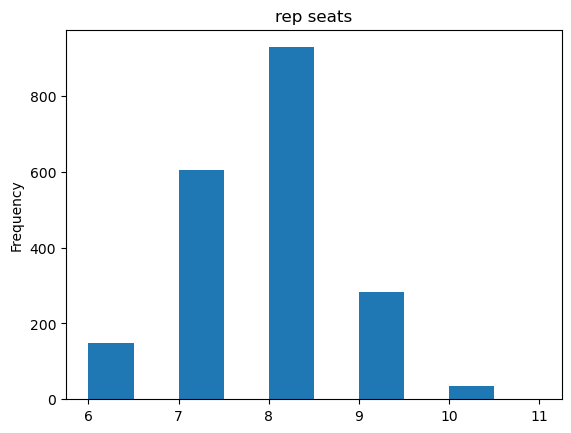

VTD stats


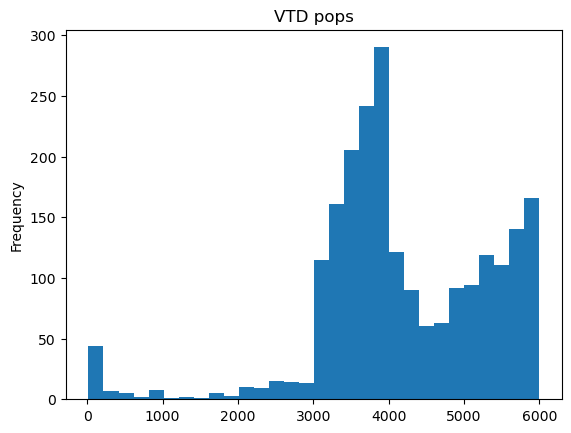

count    2208.000000
mean     4181.290259
std      1170.094650
min        15.601861
25%      3548.756976
50%      3968.532294
75%      5169.759181
max      5999.387791
dtype: float64

27627 5564 49
22142 64 32
7392 38
3460
Finished creating metamander candidate
avg rep seats  7.948
avg dem seats  5.052


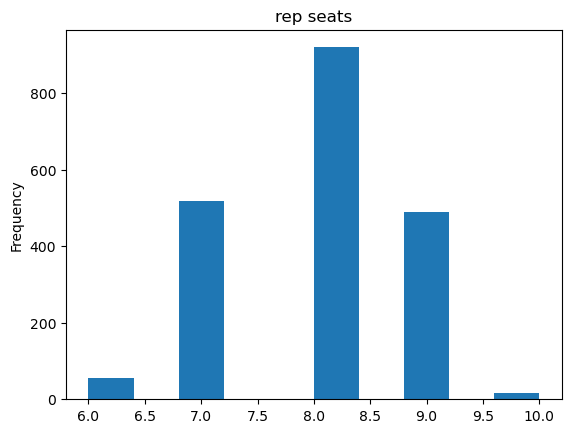

VTD stats


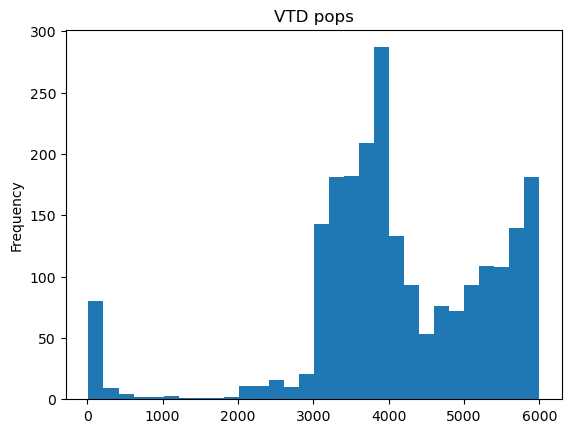

count    2234.000000
mean     4113.966300
std      1272.578113
min        15.014892
25%      3483.058152
50%      3973.454654
75%      5142.590221
max      5999.871180
dtype: float64

27627 5564 49
22142 64 32
7359 30
3396
Finished creating metamander candidate
avg rep seats  7.151
avg dem seats  5.849


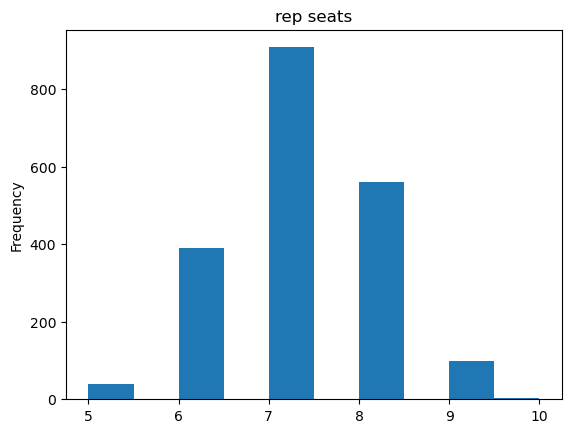

VTD stats


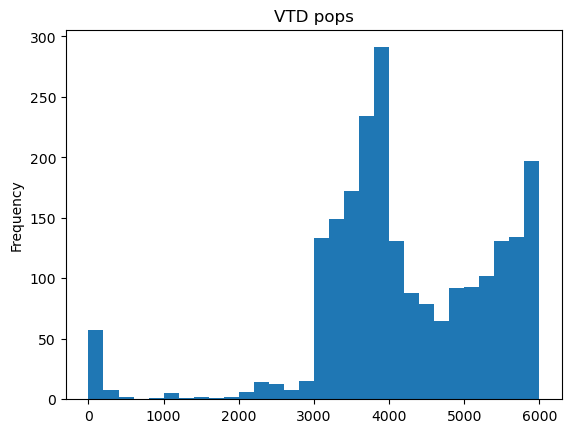

count    2226.000000
mean     4204.862600
std      1202.950325
min         0.646199
25%      3567.219590
50%      3998.530327
75%      5209.566202
max      5999.712303
dtype: float64

27627 5564 49
22142 64 32
7302 28
3396
Finished creating metamander candidate
avg rep seats  7.6495
avg dem seats  5.3505


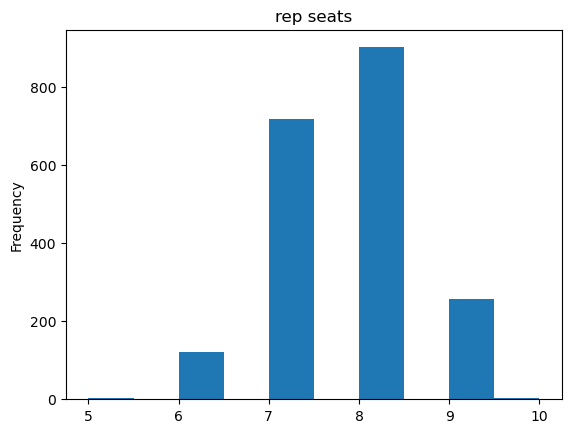

VTD stats


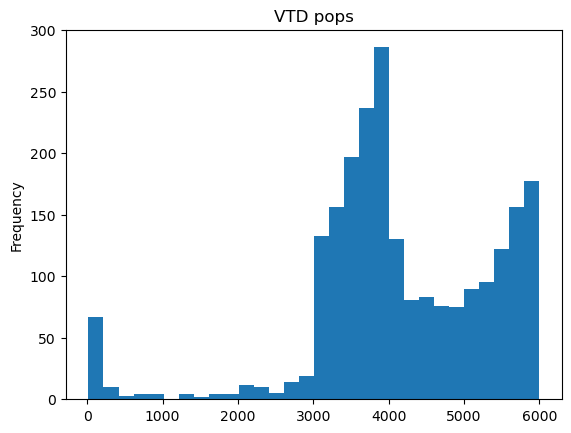

count    2256.000000
mean     4147.001310
std      1243.608433
min        15.014892
25%      3521.257166
50%      3980.501158
75%      5164.971991
max      5999.039412
dtype: float64

27627 5564 49
22142 64 32
7359 32
3348
Finished creating metamander candidate
avg rep seats  7.6075
avg dem seats  5.3925


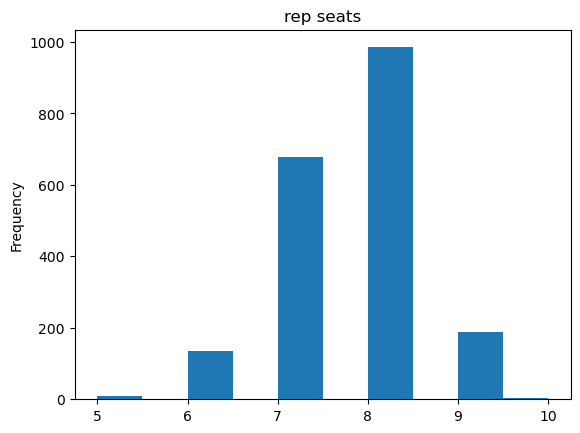

VTD stats


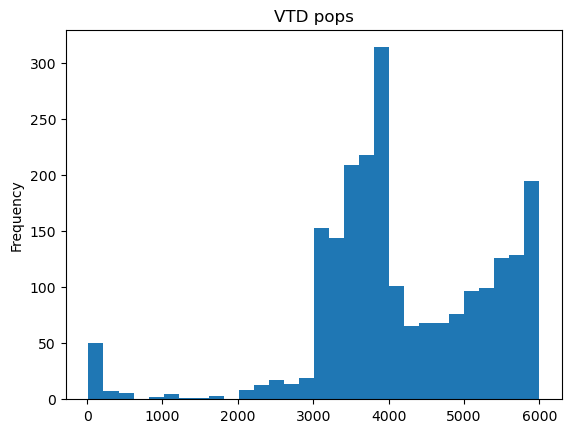

count    2208.000000
mean     4178.488424
std      1196.545544
min        17.704734
25%      3511.752566
50%      3952.480193
75%      5198.786012
max      5999.596167
dtype: float64

27627 5564 49
22142 64 32
7304 31
3389
Finished creating metamander candidate
avg rep seats  7.616
avg dem seats  5.384


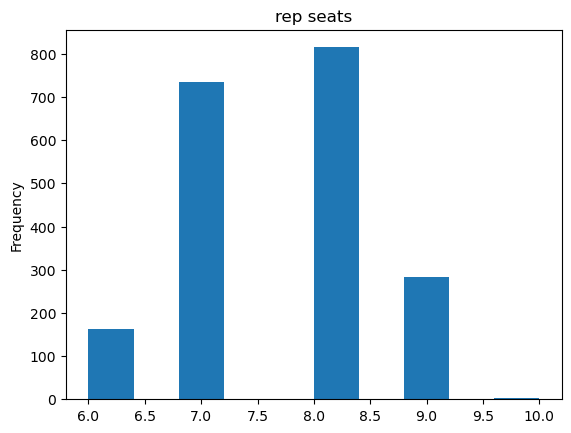

VTD stats


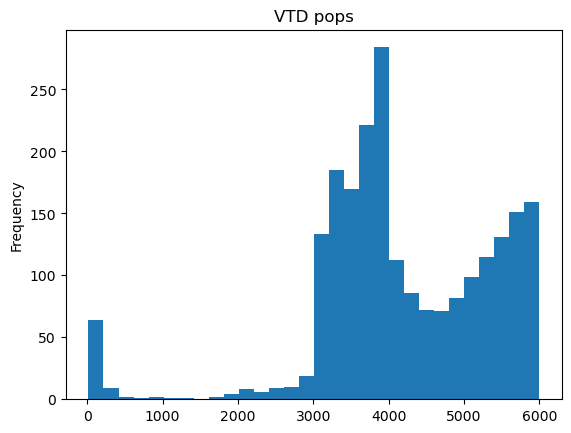

count    2209.000000
mean     4180.073205
std      1215.118869
min        15.295709
25%      3526.804252
50%      3988.546924
75%      5205.080387
max      5998.850418
dtype: float64

27627 5564 49
22142 64 32
7349 34
3408
Finished creating metamander candidate
avg rep seats  7.7575
avg dem seats  5.2425


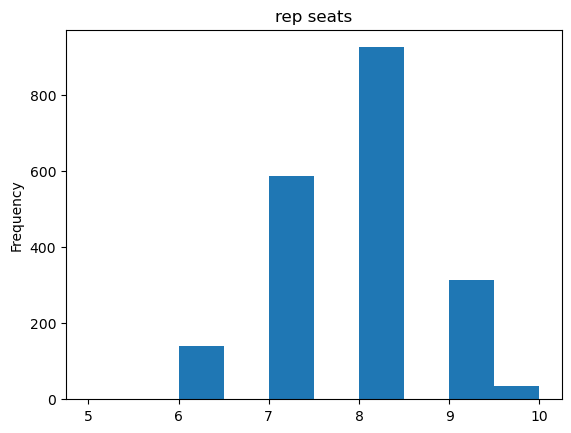

VTD stats


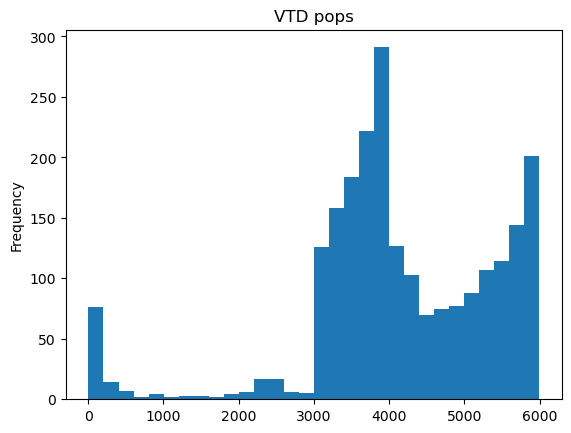

count    2255.000000
mean     4139.230433
std      1291.846609
min         4.020564
25%      3533.944723
50%      3983.067965
75%      5199.383444
max      5996.231918
dtype: float64

27627 5564 49
22142 64 32
7405 33
3385
Finished creating metamander candidate
avg rep seats  7.3985
avg dem seats  5.6015


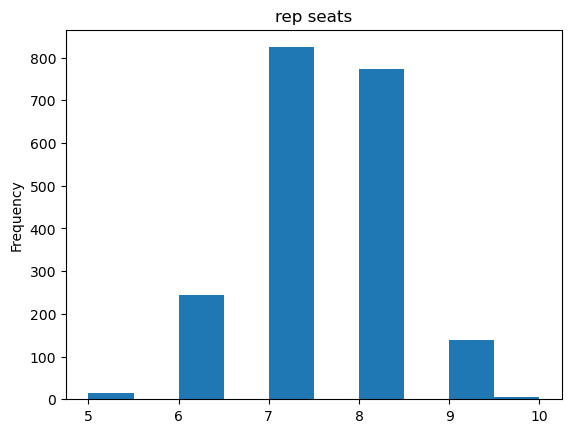

VTD stats


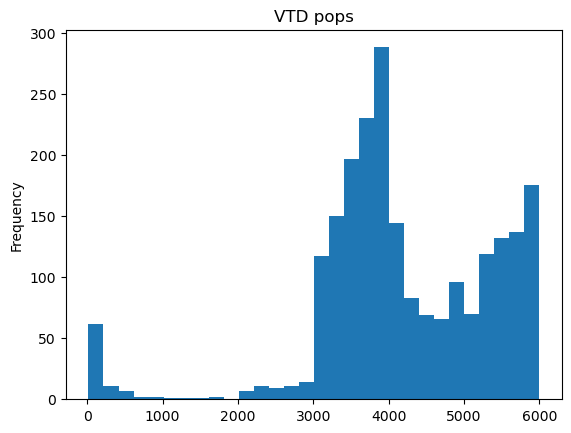

count    2214.000000
mean     4178.179653
std      1223.786625
min        15.110070
25%      3555.798019
50%      3994.084277
75%      5218.806428
max      5998.602501
dtype: float64

27627 5564 49
22142 64 32
7377 28
3444
Finished creating metamander candidate
avg rep seats  7.869
avg dem seats  5.131


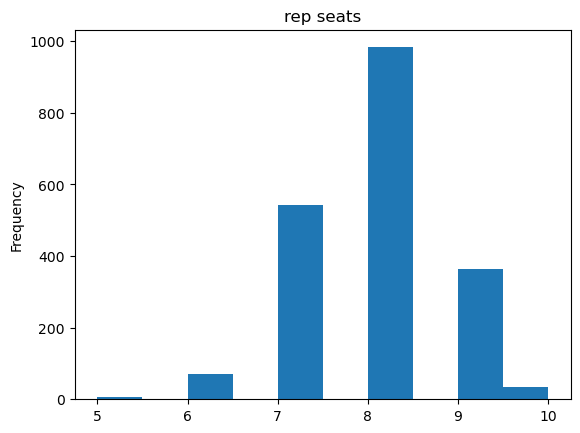

VTD stats


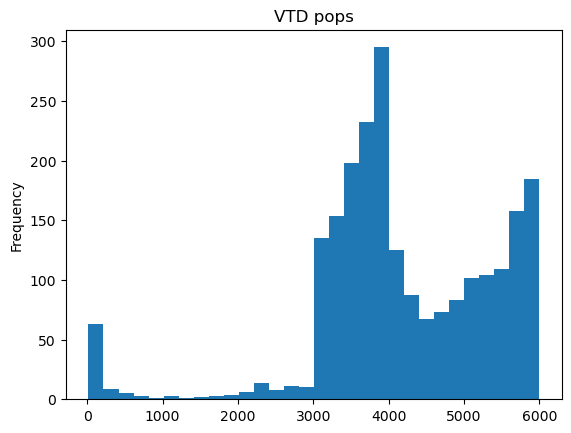

count    2250.000000
mean     4175.440821
std      1225.268851
min        15.015284
25%      3543.514694
50%      3983.023323
75%      5185.421041
max      5998.554731
dtype: float64

27627 5564 49
22142 64 32
7270 31
3360
Finished creating metamander candidate



KeyboardInterrupt



In [109]:
for part in exp_chain:
    rep_seats_won = 0
    dem_seats_won = 0
    for j in range(num_districts):
        rep_votes = 0
        dem_votes = 0
        for n in blocks_graph_test.nodes():
            if part.assignment[n] == j:
                rep_votes += blocks_graph_test.nodes[n]["rep"]
                dem_votes += blocks_graph_test.nodes[n]["dem"]
        total_seats_dem = int(dem_votes > rep_votes)
        total_seats_rep = int(rep_votes > dem_votes)
        rep_seats_won += total_seats_rep
        dem_seats_won += total_seats_dem
    seats_won_for_republicans.append(rep_seats_won)
    seats_won_for_democrats.append(dem_seats_won)
    if rep_seats_won >= 9 or rep_seats_won <= 6:
        while True:
            try:
                dem_avg, rep_avg = metamander_around_part(part = part, 
                                              graph = blocks_graph_test, 
                                              num_vtds = 2500)
            except:
                break
        
        
        if rep_avg >= 8.75 or rep_avg <= 6.5:
            optimized_part = part
            print('finished')
            break

23206
7435
2887
Finished creating metamander candidate
avg rep seats  7.626
avg dem seats  5.374


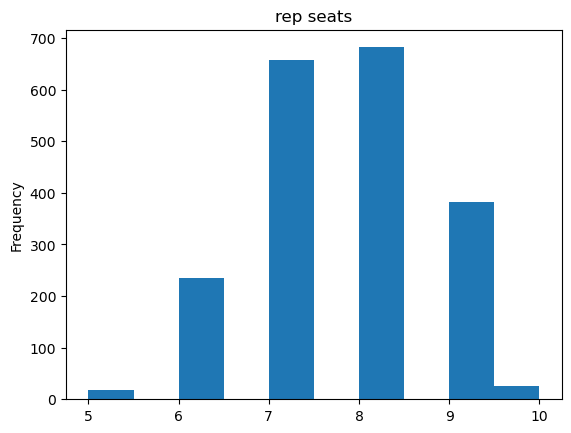

VTD stats


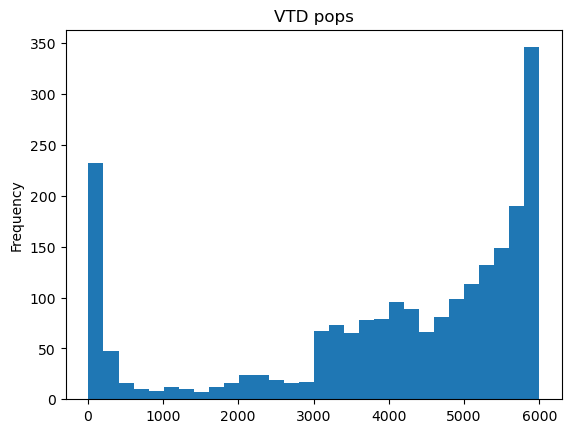

count    2193.000000
mean     4027.132722
std      1911.830851
min        10.072973
25%      3235.749199
50%      4646.782169
75%      5592.968984
max      5999.935961
dtype: float64

In [73]:
dem_avg, rep_avg = metamander_around_part(part = part, 
                                          graph = blocks_graph_test, 
                                          num_vtds = 2200)

27627 5564 49
22142 64 32
7343 32
3353
Finished creating metamander candidate
avg rep seats  7.739
avg dem seats  5.261


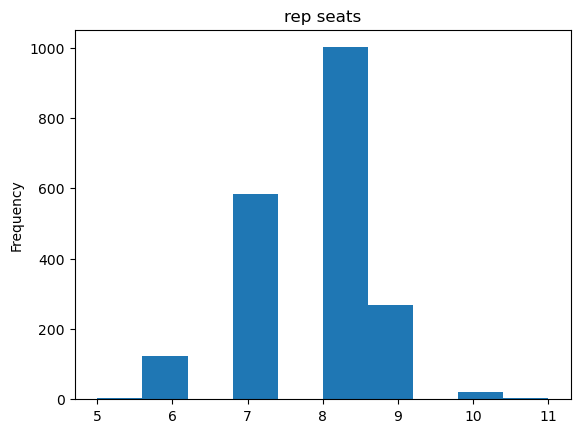

VTD stats


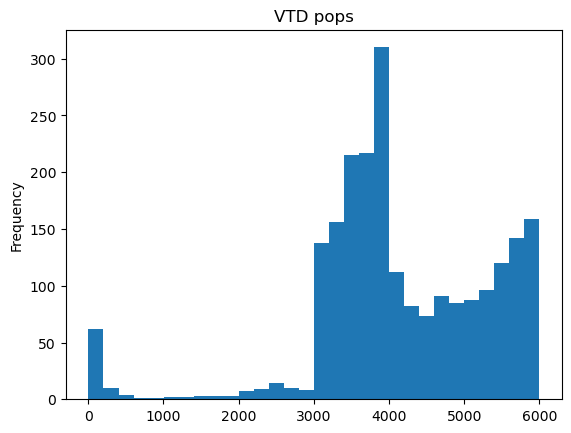

count    2222.000000
mean     4143.141059
std      1211.213489
min         1.938596
25%      3519.742115
50%      3956.869971
75%      5126.756359
max      5998.472620
dtype: float64

In [106]:
dem_avg, rep_avg = metamander_around_part(part = part, 
                                  graph = blocks_graph_test, 
                                  num_vtds = 2500)

count    2160.000000
mean     3783.032069
std      2086.843949
min         0.417500
25%      2989.103028
50%      4444.552438
75%      5506.791379
max      5999.998909
dtype: float64